In [24]:
# 1. IMPORT LIBRARIES
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [25]:
# 2.  LOAD CSV
csv_path = "csv_path = "data/twitter_training.csv"
df = pd.read_csv(csv_path, header=None)
df.columns = ['id', 'entity', 'sentiment', 'text']

# 3. FILTER & CLEAN DATA
df = df.dropna()
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
texts = df['text'].astype(str).values
labels = df['sentiment'].values


In [26]:

# 4. SPLIT DATA (avoid leakage)
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [27]:
#Calculating OOV percentage
def calculate_oov_percentage(texts, tokenizer):
    word_index = tokenizer.word_index
    num_words = tokenizer.num_words  # vocab limit
    oov_token_index = word_index.get(tokenizer.oov_token)

    total_tokens = 0
    oov_tokens = 0

    for text in texts:
        seq = tokenizer.texts_to_sequences([text])[0]
        total_tokens += len(seq)
        oov_tokens += seq.count(oov_token_index)

    if total_tokens == 0:
        return 0.0
    
    return (oov_tokens / total_tokens) * 100
oov_pct_train = calculate_oov_percentage(X_train_raw, tokenizer)
oov_pct_val = calculate_oov_percentage(X_val_raw, tokenizer)

print(f"OOV percentage in training data: {oov_pct_train:.2f}%")
print(f"OOV percentage in validation data: {oov_pct_val:.2f}%")


OOV percentage in training data: 4.93%
OOV percentage in validation data: 6.30%


In [30]:

# 5. TOKENIZATION (fit only on training data)
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>', lower=True)
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_val_seq = tokenizer.texts_to_sequences(X_val_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# 6. PADDING SEQUENCES
maxlen = 50
X_train = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# 7. ENCODE LABELS
encoder = LabelEncoder()
encoder.fit(y_train_raw)  # fit on training labels only
y_train = encoder.transform(y_train_raw)
y_val = encoder.transform(y_val_raw)
y_test = encoder.transform(y_test_raw)

# 8. LOAD GLOVE EMBEDDINGS
glove_path = "glove/glove.6B.100d.txt" # Update if needed
embedding_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
print(f"Loaded {len(embedding_index)} word vectors from GloVe.")
# Checking embedding dim
first_vector = next(iter(embedding_index.values()))
embedding_dim = len(first_vector)
print(f"Embedding dimension detected: {embedding_dim}")

# 9. CREATE EMBEDDING MATRIX
vocab_size = min(10000, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

# 10. BUILD MODEL WITH GLOVE
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=True # Set to True if you want to fine-tune embeddings
    ),
    LSTM(64, dropout=0.2),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, maxlen))
model.summary()

# 11. HANDLE CLASS IMBALANCE
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 12. TRAIN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# 11. EVALUATE ON TEST SET
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# 12. CLASSIFICATION REPORT
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))


Loaded 400000 word vectors from GloVe.
Embedding dimension detected: 100


C:\Users\HP\Documents\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 50, 100)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,042,435 (3.98 MB)

 Trainable params: 1,042,435 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
669/669 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.4162 - loss: 1.0532 - val_accuracy: 0.6270 - val_loss: 0.9019
Epoch 2/20
669/669 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.5719 - loss: 0.9600 - val_accuracy: 0.6492 - val_loss: 0.8633
Epoch 3/20
669/669 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5820 - loss: 0.9322 - val_accuracy: 0.4981 - val_loss: 1.0144
Epoch 4/20
669/669 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.4781 - loss: 1.0133 - val_accuracy: 0.5149 - val_loss: 0.9491
Epoch 5/20
669/669 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.5499 - loss: 0.9482 - val_accuracy: 0.6603 - val_loss: 0.8038
Epoch 6/20
669/669 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.6628 - loss: 0.7906 - val_accuracy: 0.6288 - val_loss: 0.8275
Epoch 7/20
669/669 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.6686 - loss: 0.7812 - val_accuracy: 0.6920 - val_loss: 0.7392
Epoch 8/20
669/669 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - accuracy: 0.7181 - loss: 0.7055 - 

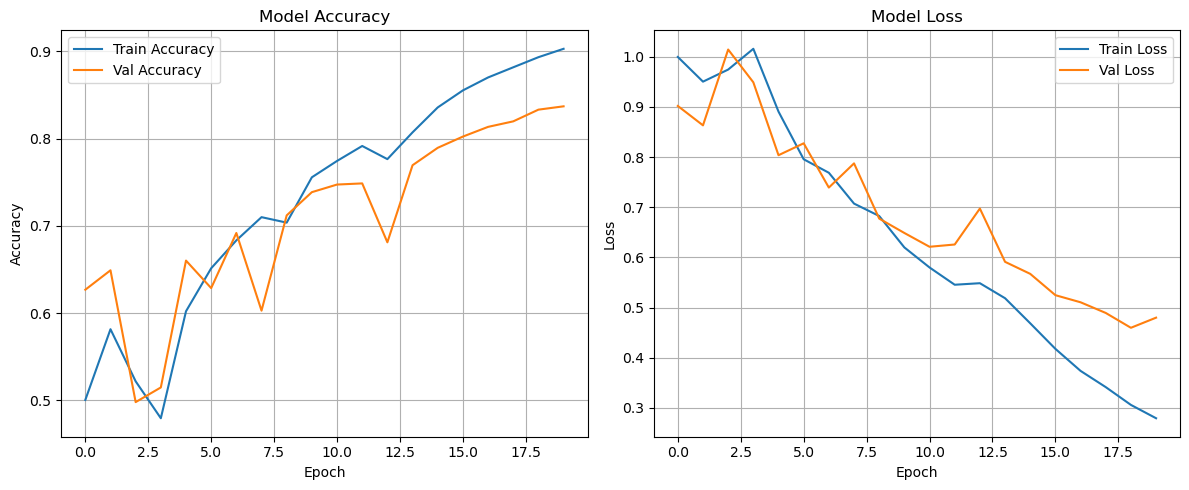

In [31]:

# 13. PLOT TRAINING HISTORY
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


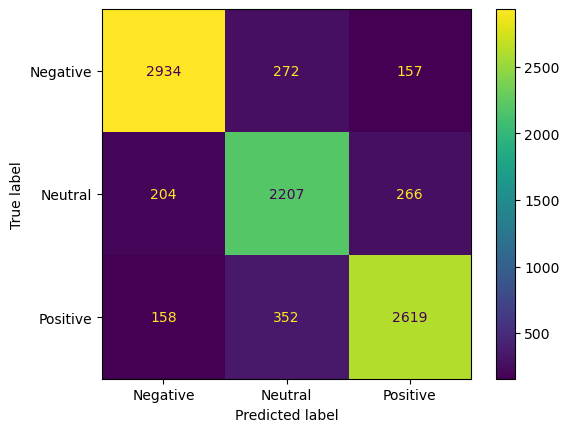

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot()


In [36]:
import os

# Create 'models' folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the model
model.save("models/sentiment_model.h5")
print("Model saved to models/sentiment_model.h5")



Model saved to models/sentiment_model.h5
